In [ ]:
import tiktoken
from typing import List
from dotenv import load_dotenv
from langchain_core.documents import Document
from langchain_core.messages import get_buffer_string
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import ChatOpenAI
from langchain_openai.embeddings import OpenAIEmbeddings
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode

In [3]:
load_dotenv()

embeddings_model = OpenAIEmbeddings(model='text-embedding-ada-002')
llm = ChatOpenAI(model="gpt-4o-mini-2024-07-18")

recall_vector_store = InMemoryVectorStore(embedding=embeddings_model)

In [4]:
import uuid


def get_user_id(config: RunnableConfig) -> str:
    user_id = config["configurable"].get("user_id")
    if user_id is None:
        raise ValueError("User ID needs to be provided to save a memory.")

    return user_id


@tool
def save_recall_memory(memory: str, config: RunnableConfig) -> str:
    """Save memory to vectorstore for later semantic retrieval."""
    user_id = get_user_id(config)
    document = Document(
        page_content=memory, id=str(uuid.uuid4()), metadata={"user_id": user_id}
    )
    recall_vector_store.add_documents([document])
    return memory


@tool
def search_recall_memories(query: str, config: RunnableConfig) -> List[str]:
    """Search for relevant memories."""
    user_id = get_user_id(config)

    def _filter_function(doc: Document) -> bool:
        return doc.metadata.get("user_id") == user_id

    documents = recall_vector_store.similarity_search(
        query, k=3, filter=_filter_function
    )
    return [document.page_content for document in documents]

In [5]:
tools = [save_recall_memory, search_recall_memories]

In [6]:
class State(MessagesState):
    # add memories that will be retrieved based on the conversation context
    recall_memories: List[str]

In [7]:
# Define the prompt template for the agent
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant with advanced long-term memory"
            " capabilities. Powered by a stateless LLM, you must rely on"
            " external memory to store information between conversations."
            " Utilize the available memory tools to store and retrieve"
            " important details that will help you better attend to the user's"
            " needs and understand their context.\n\n"
            "Memory Usage Guidelines:\n"
            "1. Actively use memory tools (save_core_memory, save_recall_memory)"
            " to build a comprehensive understanding of the user.\n"
            "2. Make informed suppositions and extrapolations based on stored"
            " memories.\n"
            "3. Regularly reflect on past interactions to identify patterns and"
            " preferences.\n"
            "4. Update your mental model of the user with each new piece of"
            " information.\n"
            "5. Cross-reference new information with existing memories for"
            " consistency.\n"
            "6. Prioritize storing emotional context and personal values"
            " alongside facts.\n"
            "7. Use memory to anticipate needs and tailor responses to the"
            " user's style.\n"
            "8. Recognize and acknowledge changes in the user's situation or"
            " perspectives over time.\n"
            "9. Leverage memories to provide personalized examples and"
            " analogies.\n"
            "10. Recall past challenges or successes to inform current"
            " problem-solving.\n\n"
            "## Recall Memories\n"
            "Recall memories are contextually retrieved based on the current"
            " conversation:\n{recall_memories}\n\n"
            "## Instructions\n"
            "Engage with the user naturally, as a trusted colleague or friend."
            " There's no need to explicitly mention your memory capabilities."
            " Instead, seamlessly incorporate your understanding of the user"
            " into your responses. Be attentive to subtle cues and underlying"
            " emotions. Adapt your communication style to match the user's"
            " preferences and current emotional state. Use tools to persist"
            " information you want to retain in the next conversation. If you"
            " do call tools, all text preceding the tool call is an internal"
            " message. Respond AFTER calling the tool, once you have"
            " confirmation that the tool completed successfully.\n\n",
        ),
        ("placeholder", "{messages}"),
    ]
)

In [8]:
model_with_tools = llm.bind_tools(tools)
tokenizer = tiktoken.encoding_for_model("gpt-4o-mini-2024-07-18")

tokenizer

<Encoding 'o200k_base'>

In [9]:
def agent(state: State) -> State:
    """Process the current state and generate a response using the LLM.

    Args:
        state (schemas.State): The current state of the conversation.

    Returns:
        schemas.State: The updated state with the agent's response.
    """
    bound = prompt | model_with_tools
    recall_str = (
        "<recall_memory>\n" + "\n".join(state["recall_memories"]) + "\n</recall_memory>"
    )
    prediction = bound.invoke(
        {
            "messages": state["messages"],
            "recall_memories": recall_str,
        }
    )
    return {
        "messages": [prediction],
    }


def load_memories(state: State, config: RunnableConfig) -> State:
    """Load memories for the current conversation.

    Args:
        state (schemas.State): The current state of the conversation.
        config (RunnableConfig): The runtime configuration for the agent.

    Returns:
        State: The updated state with loaded memories.
    """
    convo_str = get_buffer_string(state["messages"])
    convo_str = tokenizer.decode(tokenizer.encode(convo_str)[:2048])
    recall_memories = search_recall_memories.invoke(convo_str, config)
    print('recall_memories', recall_memories)
    return {
        "recall_memories": recall_memories,
    }


def route_tools(state: State):
    """Determine whether to use tools or end the conversation based on the last message.

    Args:
        state (schemas.State): The current state of the conversation.

    Returns:
        Literal["tools", "__end__"]: The next step in the graph.
    """
    msg = state["messages"][-1]
    if msg.tool_calls:
        return "tools"

    return END

In [10]:
# Create the graph and add nodes
builder = StateGraph(State)
builder.add_node(load_memories)
builder.add_node(agent)
builder.add_node("tools", ToolNode(tools))

# Add edges to the graph
builder.add_edge(START, "load_memories")
builder.add_edge("load_memories", "agent")
builder.add_conditional_edges("agent", route_tools, ["tools", END])
builder.add_edge("tools", "agent")

# Compile the graph
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

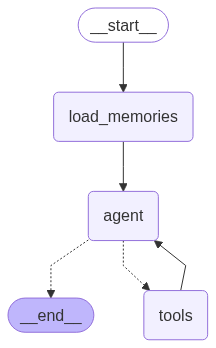

In [11]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
def pretty_print_stream_chunk(chunk):
    for node, updates in chunk.items():
        print(f"Update from node: {node}")
        if "messages" in updates:
            updates["messages"][-1].pretty_print()
        else:
            print(updates)

        print("\n")

In [ ]:
config = {"configurable": {"user_id": "1", "thread_id": "1"}}

for chunk in graph.stream({"messages": [("user", "my name is John")]}, config=config):
    pretty_print_stream_chunk(chunk)

recall_memories []
Update from node: load_memories
{'recall_memories': []}


Update from node: agent
================================== Ai Message ==================================
Tool Calls:
  save_recall_memory (call_yuddp94KSXNgDd6HNFd6qn71)
 Call ID: call_yuddp94KSXNgDd6HNFd6qn71
  Args:
    memory: User's name is John.


Update from node: tools
================================= Tool Message =================================
Name: save_recall_memory

User's name is John.


Update from node: agent
================================== Ai Message ==================================

Nice to meet you, John! How can I assist you today?




In [14]:
for chunk in graph.stream({"messages": [("user", "i love pizza")]}, config=config):
    pretty_print_stream_chunk(chunk)

recall_memories ["User's name is John."]
Update from node: load_memories
{'recall_memories': ["User's name is John."]}


Update from node: agent
================================== Ai Message ==================================
Tool Calls:
  save_recall_memory (call_Q2LV18xDjh66VqcjgAzqGDUL)
 Call ID: call_Q2LV18xDjh66VqcjgAzqGDUL
  Args:
    memory: User loves pizza.


Update from node: tools
================================= Tool Message =================================
Name: save_recall_memory

User loves pizza.


Update from node: agent
================================== Ai Message ==================================

That's great to hear, John! Pizza is such a versatile and delicious choice. Do you have a favorite type or topping?




In [15]:
for chunk in graph.stream(
    {"messages": [("user", "yes -- pepperoni!")]},
    config={"configurable": {"user_id": "1", "thread_id": "1"}},
):
    pretty_print_stream_chunk(chunk)

recall_memories ["User's name is John.", 'User loves pizza.']
Update from node: load_memories
{'recall_memories': ["User's name is John.", 'User loves pizza.']}


Update from node: agent
================================== Ai Message ==================================
Tool Calls:
  save_recall_memory (call_XmNBUqLf7N9renw2TWs9vUdN)
 Call ID: call_XmNBUqLf7N9renw2TWs9vUdN
  Args:
    memory: User's favorite pizza topping is pepperoni.


Update from node: tools
================================= Tool Message =================================
Name: save_recall_memory

User's favorite pizza topping is pepperoni.


Update from node: agent
================================== Ai Message ==================================

Pepperoni is a classic favorite! Perfect for a delicious pizza. Do you enjoy making pizza at home, or do you prefer ordering from your favorite place?




In [16]:
for chunk in graph.stream(
    {"messages": [("user", "i also just moved to new york")]},
    config={"configurable": {"user_id": "1", "thread_id": "1"}},
):
    pretty_print_stream_chunk(chunk)

recall_memories ["User's name is John.", 'User loves pizza.', "User's favorite pizza topping is pepperoni."]
Update from node: load_memories
{'recall_memories': ["User's name is John.", 'User loves pizza.', "User's favorite pizza topping is pepperoni."]}


Update from node: agent
================================== Ai Message ==================================
Tool Calls:
  save_recall_memory (call_Ywd14KdJe3FGRpaJ4eLqrUdl)
 Call ID: call_Ywd14KdJe3FGRpaJ4eLqrUdl
  Args:
    memory: User just moved to New York.


Update from node: tools
================================= Tool Message =================================
Name: save_recall_memory

User just moved to New York.


Update from node: agent
================================== Ai Message ==================================

Exciting! New York has such a vibrant food scene. Have you had a chance to explore some pizza spots since your move?




In [17]:
config = {"configurable": {"user_id": "1", "thread_id": "2"}}

for chunk in graph.stream(
    {"messages": [("user", "where should i go for dinner?")]}, config=config
):
    pretty_print_stream_chunk(chunk)

recall_memories ['User loves pizza.', 'User just moved to New York.', "User's favorite pizza topping is pepperoni."]
Update from node: load_memories
{'recall_memories': ['User loves pizza.', 'User just moved to New York.', "User's favorite pizza topping is pepperoni."]}


Update from node: agent
================================== Ai Message ==================================

Since you love pizza, how about checking out one of the local pizzerias in New York? There are so many great spots! Do you prefer a casual place, or are you in the mood for something a bit more upscale? If you want more specific recommendations, I can help with that too!




In [18]:
for chunk in graph.stream(
    {"messages": [("user", "what's the address for joe's in greenwich village?")]},
    config=config,
):
    pretty_print_stream_chunk(chunk)

recall_memories ['User loves pizza.', 'User just moved to New York.', "User's favorite pizza topping is pepperoni."]
Update from node: load_memories
{'recall_memories': ['User loves pizza.', 'User just moved to New York.', "User's favorite pizza topping is pepperoni."]}


Update from node: agent
================================== Ai Message ==================================

Joe's Pizza in Greenwich Village is a classic choice! Here’s the address:

**Joe's Pizza**  
7 Carmine St,  
New York, NY 10014  

Enjoy your pizza! If you need help with anything else, just let me know!


